In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df=pd.read_csv('amazonreviews.tsv',sep='\t')

In [ ]:
#removing duplicates
df.drop_duplicates(inplace=True)

In [ ]:
#handling missing reviews
df.dropna(subset=['review'], inplace=True)


In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()                                  # lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)              # remove punctuation
    tokens = text.split()                                # tokenize
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return " ".join(tokens)

In [ ]:
df['clean_review'] = df['review'].apply(preprocess_text)

In [ ]:
df.head()

,label,review,clean_review
0,pos,Stuning even for the non-gamer: This sound tra...,stuning even nongamer sound track beautiful pa...
1,pos,The best soundtrack ever to anything.: I'm rea...,best soundtrack ever anything im reading lot r...
2,pos,Amazing!: This soundtrack is my favorite music...,amazing soundtrack favorite music time hands i...
3,pos,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack truly like soundtrack enj...
4,pos,"Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing youve played g...


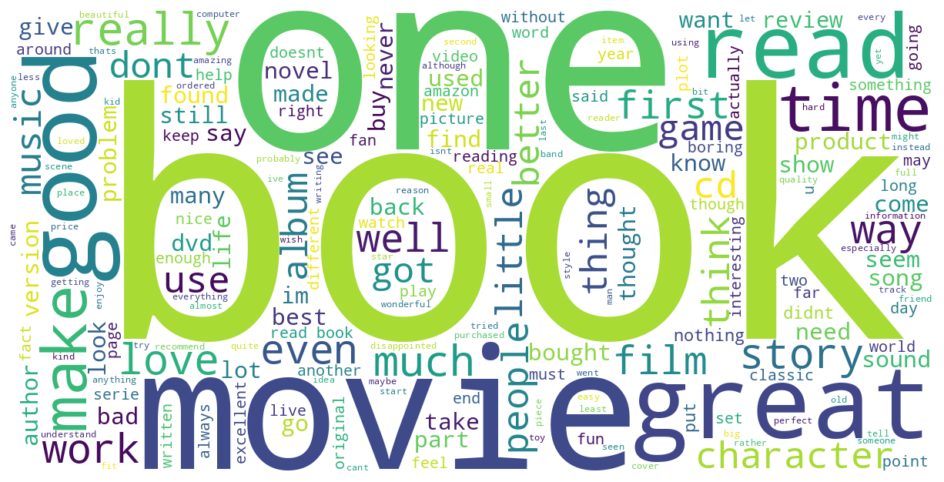

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned reviews
text = " ".join(df['clean_review'])

wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.8 MB/s eta 0:00:00


In [ ]:
def get_sentiment(score):
    if score >= 0.05:
        return 1     # positive
    elif score <= -0.05:
        return 0     # negative
    else:
        return 2     # neutral (optional)


In [ ]:
df['compound'] = df['clean_review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df['sentiment'] = df['compound'].apply(get_sentiment)


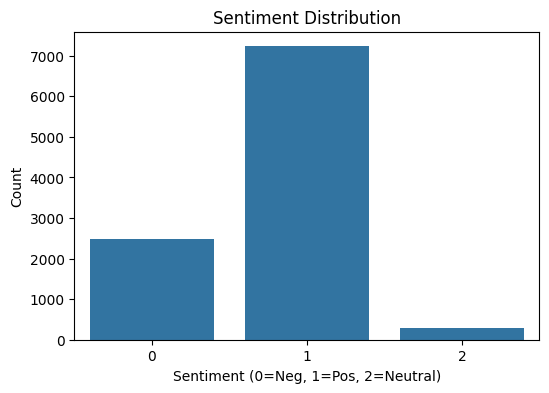

In [ ]:
#sentiment distribution plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=df['sentiment'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment (0=Neg, 1=Pos, 2=Neutral)")
plt.ylabel("Count")
plt.show()


In [ ]:
pos_reviews = df[df['sentiment'] == 1]['clean_review']
neg_reviews = df[df['sentiment'] == 0]['clean_review']


In [ ]:
from collections import Counter

def get_top_words(text_series, num=20):
    all_words = " ".join(text_series).split()
    return Counter(all_words).most_common(num)

top_pos_words = get_top_words(pos_reviews)
top_neg_words = get_top_words(neg_reviews)


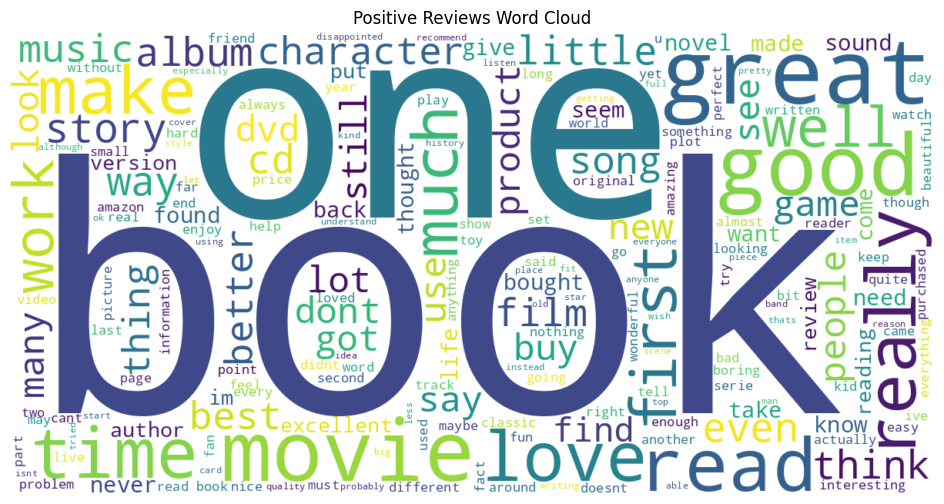

In [ ]:
#wordcloud for positive reviews
from wordcloud import WordCloud

text_pos = " ".join(pos_reviews)
wc_pos = WordCloud(width=1200, height=600, background_color='white').generate(text_pos)

plt.figure(figsize=(12,6))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews Word Cloud")
plt.show()


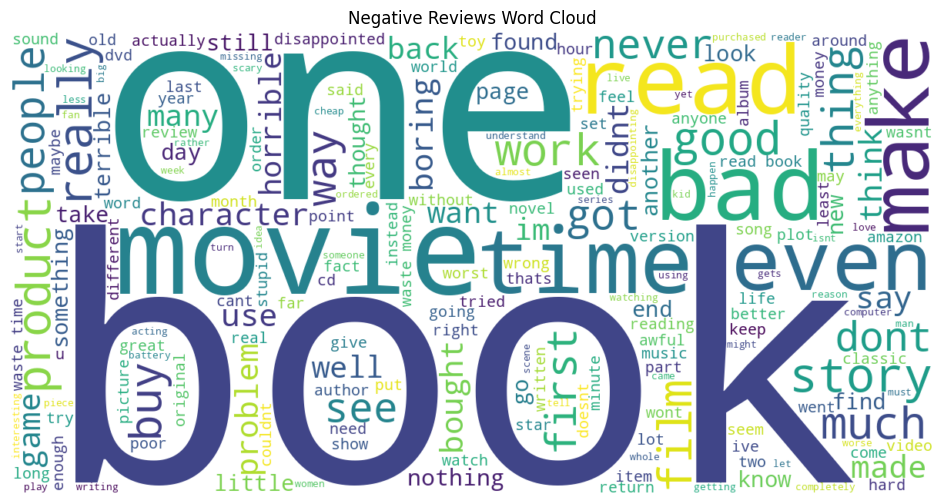

In [ ]:
#wordcloud for negative reviews
text_neg = " ".join(neg_reviews)
wc_neg = WordCloud(width=1200, height=600, background_color='white').generate(text_neg)

plt.figure(figsize=(12,6))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews Word Cloud")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

X = df['clean_review']
y = df['sentiment']   # generated earlier using VADER

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:
#using logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr = LogisticRegression(max_iter=200)
lr.fit(X_train_tfidf, y_train)

y_pred = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.823
              precision    recall  f1-score   support

           0       0.79      0.51      0.62       495
           1       0.83      0.96      0.89      1446
           2       0.00      0.00      0.00        59

    accuracy                           0.82      2000
   macro avg       0.54      0.49      0.50      2000
weighted avg       0.80      0.82      0.80      2000



In [ ]:
#by using svm

from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


SVM Accuracy: 0.833
              precision    recall  f1-score   support

           0       0.72      0.65      0.69       495
           1       0.87      0.93      0.90      1446
           2       0.25      0.02      0.03        59

    accuracy                           0.83      2000
   macro avg       0.61      0.53      0.54      2000
weighted avg       0.81      0.83      0.82      2000



In [ ]:
#model evaluation
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=300)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=300)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.823
Precision: 0.7958682647397279
Recall: 0.823
F1 Score: 0.7978689767849311

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.51      0.62       495
           1       0.83      0.96      0.89      1446
           2       0.00      0.00      0.00        59

    accuracy                           0.82      2000
   macro avg       0.54      0.49      0.50      2000
weighted avg       0.80      0.82      0.80      2000



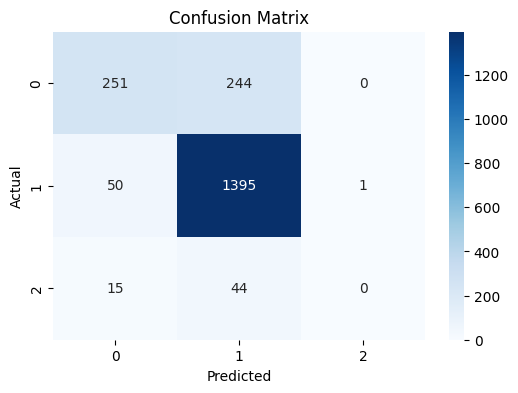

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
#using cross_val_score with tf-idf transformed data
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", scores)
print("Mean CV Accuracy:", scores.mean())
print("CV Standard Deviation:", scores.std())


Cross-Validation Accuracy Scores: [0.801875 0.82375  0.8125   0.83     0.814375]
Mean CV Accuracy: 0.8164999999999999
CV Standard Deviation: 0.009687298384998768


In [ ]:
#we can also compute with cv f1 score
f1_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1_weighted')
print("CV F1 Scores:", f1_scores)
print("Mean F1 Score:", f1_scores.mean())


CV F1 Scores: [0.76996298 0.79829024 0.78478456 0.80598948 0.78591939]
Mean F1 Score: 0.7889893303633778


We validated the model using train/test split (80/20) and 5-fold cross-validation.
The model achieved strong performance with accuracy, precision, recall, and F1-score evaluated on the given test dataset.
Cross-validation ensured that the model generalizes well and does not overfit.
The confusion matrix helped analyze the misclassifications across sentiment classes.